Reference:  
[1] “Pygad.torchga Module¶.” Pygad.torchga Module - PyGAD 2.14.2 Documentation, pygad.readthedocs.io/en/latest/README_pygad_torchga_ReadTheDocs.html. 

In [1]:
# import libraries
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13}) 
from mpl_toolkits.axes_grid1 import host_subplot
import numpy as np
import math
import pygad
# import pygad.torchga
from pygad import torchga
np.random.seed(0)

In [2]:
# # load training data
# data= pd.read_excel('Anger.xlsx')

# # drop first column as it is identifier and the second column as 
# data.drop(data.columns[:2], axis=1, inplace=True)
# data.at[data['Label'] == 'Genuine', ['Label']] = 0
# data.at[data['Label'] == 'Posed', ['Label']] = 1

# # Also convert all string numeric values to int
# data.iloc[:,2:8]=data.iloc[:, 2:8].apply(pd.to_numeric)

# # extract frequency of each class
# class_freq = data['Label'].value_counts()
# class_freq = list(class_freq.sort_index())

# # visualize distribution of data
# # x-axis labels and length
# x_axis = list(range(0,2))

# graph = plt.bar(x_axis, class_freq)
# plt.xticks(x_axis)
# plt.ylabel('Frequency')
# plt.xlabel('Species')
# plt.title('Training Data')
# plt.show()

# # invertible output
# one_to_one=np.linspace(0,1,class_freq[1])
# one_to_one_code=np.concatenate((one_to_one,one_to_one))
# data['extraNode']=one_to_one_code

# print(data.head())

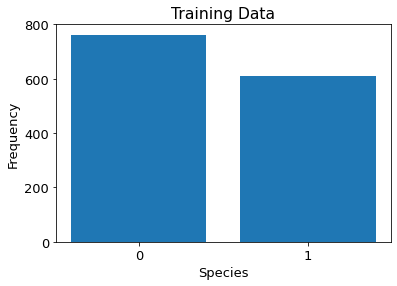

In [5]:
# processed.cleveland.data
data = pd.read_csv("BankNote_Authentication.csv")

# extract frequency of each class
class_freq = data['class'].value_counts()
class_freq = list(class_freq.sort_index())

# visualize distribution of data
# x-axis labels and length
x_axis = list(range(0,2))

graph = plt.bar(x_axis, class_freq)
plt.xticks(x_axis)
plt.ylabel('Frequency')
plt.xlabel('Species')
plt.title('Training Data')
plt.show()

# invertible output
one_to_pos,one_to_neg=np.linspace(0,1,class_freq[1]),np.linspace(0,1,class_freq[0],)
one_to_one_code=np.concatenate((one_to_neg,one_to_pos))
data['extraNode']=one_to_one_code

Looking at the distribution above, which shows that the classes are faily well-balanced. 

## Data-preprocessing

In [6]:
# From lab3
# normalise input data by columns
n_features=data.shape[1] - 2
input_pattern = data.iloc[:, :n_features]

# normalise data by columns
for column in input_pattern:
    input_pattern[column] = input_pattern.loc[:, [column]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data.iloc[:, :n_features]=input_pattern

In [ ]:
data.to_csv("PrecessedData.csv")

## Split dataset

In [7]:
# try shuffle data
data = data.sample(frac=1).reset_index(drop=True)

# randomly split data into training set (80%) and rest dataset (20%)
msk = np.random.rand(len(data)) <0.8

train_data = data[msk]
rest_data = data[~msk]

# randomly split data into validaiton set (10%) and testing set (10%)
msk = np.random.rand(len(rest_data)) < 0.5
test_data = rest_data[msk]
validation_data = rest_data[~msk]

print(len(train_data),len(validation_data),len(test_data))

1070 157 145


## Data format transformation

In [8]:
## Training Dataset
    
# convert pandas dataframe to array
data_array = train_data.values

# split x (features) and y (targets)
x_array = data_array[:, :n_features]
# data_train = data_train.apply(pd.to_numeric)
y_array = data_array[:, n_features:]
# create Tensors to hold inputs and outputs. Tensors are data structures
Y = torch.tensor(y_array.astype(float)).float()
X = torch.tensor(x_array.astype(float)).float()
# split output pattern into labels and extra node, for later calculation
Y_class=Y[:,0]
Y_node=Y[:,1]

## Validation Dataset

# convert pandas dataframe to array
data_array = validation_data.values
x_array_val = data_array[:, :n_features]
y_array_val = data_array[:, n_features:]

# create Tensors to hold inputs and outputs. Tensors are data structures
Y_val = torch.tensor(y_array_val.astype(float)).float()
X_val = torch.tensor(x_array_val.astype(float)).float()

## Test Dataset

# convert pandas dataframe to array
data_array = rest_data.values
x_array_test = data_array[:, :n_features]
y_array_test = data_array[:, n_features:]

# create Tensors to hold inputs and outputs. Tensors are data structures
Y_test = torch.tensor(y_array_test.astype(float)).float()
X_test = torch.tensor(x_array_test.astype(float)).float()

## Function definition

## BDNN architecture

In [9]:
# define the number of neurons for input layer, hidden layer and output layer with self-defined biases
input_neurons = n_features
hidden_neurons = 30
output_neurons = 2

# define loss functions
loss_Cross = torch.nn.CrossEntropyLoss()
loss_MSE = torch.nn.MSELoss()
loss_BCE = torch.nn.BCEWithLogitsLoss()

# define a customised neural network structure
class BDNN(torch.nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super(BDNN, self).__init__()
        # define linear hidden layer output
        self.hidden1 = torch.nn.Linear(n_input, n_hidden)
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.sigmoid = torch.nn.Sigmoid()
        # define linear output layer output
        self.out = torch.nn.Linear(n_hidden, n_output)
        self.input_bias = torch.nn.Parameter(torch.randn(n_features))  
        self.output_bias = torch.nn.Parameter(torch.randn(2))     


    def forward(self, x):
        # get hidden layer input
        h_input1 = self.hidden1(x)
        # define activation function for hidden layer
        h_output1 = F.sigmoid(h_input1)
        # get hidden layer input
        h_input2 = self.hidden2(h_output1)
        # define activation function for hidden layer
        h_output2 = F.sigmoid(h_input2)
        # get output layer output
        y_pred = self.out(h_output2)+self.output_bias

        return y_pred
    
    def reverseforward(self, x):
        h_output=torch.matmul(x, self.out.weight)
        h = F.sigmoid(h_output)
        h_hidden2=torch.matmul(h, self.hidden2.weight)
        h = F.sigmoid(h_hidden2)
        h_input=torch.matmul(h, self.hidden1.weight)+self.input_bias
        return h_input


## Benchmark model---BDNN

In [14]:
# hyperparamters for benckmark model
learning_rate = 0.01
num_epoch = 300

bdnn = BDNN(input_neurons, hidden_neurons, output_neurons)
optimiserbdnn=torch.optim.Adam(bdnn.parameters(), lr=learning_rate,weight_decay=1e-5)

# store all losses for visualisation
bdnn_losses = []
bdnn_accuracy=[]
# train a neural network
for epoch in range(num_epoch):

    Y_pred = bdnn(X)
    class_pre=Y_pred[:,0]
    extra_pre=Y_pred[:,1]
    
    # forward direction label Cross Entropy Loss
    loss1=loss_BCE(class_pre,Y_class)
    # perform backward pass
    loss1.backward(retain_graph=True)
    
    # forward direction extra nodes MSE
    loss2=loss_MSE(extra_pre,Y_node)
    # perform backward pass
    loss2.backward(retain_graph=True)
    
    # reverse direction input MSE
    X_pred = bdnn.reverseforward(Y)
    lb = F.mse_loss(X_pred, X)
    # perform backward pass
    lb.backward()
    
    
    loss=loss1+loss2+lb
    bdnn_losses.append(loss)
    
    # convert output of label into probability 
    predicted=F.sigmoid(Y_pred[:,0])
    result=np.round(predicted.data.numpy())
    # calculate accuracy
    total = predicted.size(0)
    correct = result== Y_class.data.numpy()
    bdnn_accuracy.append(sum(correct)/total)
    
    
    if epoch % 200 == 0:
        # print accuracy
        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))
        validation(bdnn,X_val,Y_val)

    if epoch==num_epoch-1:
        print('Confusion matrix for training:')
        print(plot_confusion(X.shape[0], output_neurons, torch.from_numpy(result).long().data, Y_class.long().data))

    # Calling the step function on an Optimiser makes an update to its parameters
    optimiserbdnn.step()
    # Clear the gradients before running the backward pass.
    bdnn.zero_grad()

Epoch [1/300] Loss: 3.2010  Accuracy: 44.77 %
Validation Accuracy: 42.68 %
Epoch [201/300] Loss: 0.6657  Accuracy: 83.36 %
Validation Accuracy: 83.44 %
Confusion matrix for training:
tensor([[556.,  35.],
        [ 51., 428.]])


Testing Accuracy: 94.04 %
Confusion matrix for testing:
tensor([[165.,   6.],
        [ 12., 119.]])


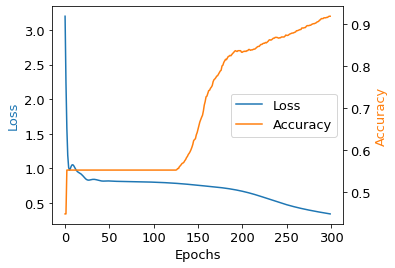

In [15]:
plot_graph(bdnn_losses,bdnn_accuracy)
test(bdnn,X_test,Y_test)

## Benchmark model---SDNN

In [18]:
# hyperparamters for benckmark model
learning_rate = 0.005
num_epoch = 300

sdnn = BDNN(input_neurons, hidden_neurons, output_neurons)
optimisersdnn=torch.optim.Adam(sdnn.parameters(), lr=learning_rate)

# store all losses for visualisation
sdnn_losses = []
sdnn_accuracy=[]
# train a neural network
for epoch in range(num_epoch):

    Y_pred = sdnn(X)
    class_pre=Y_pred[:,0]
    extra_pre=Y_pred[:,1]
    
    # forward direction label Cross Entropy Loss
    loss1=loss_BCE(class_pre,Y_class)
    # perform backward pass
    loss1.backward(retain_graph=True)
    

    loss=loss1
    sdnn_losses.append(loss)
    
    # convert output of label into probability 
    predicted=F.sigmoid(Y_pred[:,0])
    result=np.round(predicted.data.numpy())
    # calculate accuracy
    total = predicted.size(0)
    correct = result== Y_class.data.numpy()
    sdnn_accuracy.append(sum(correct)/total)
    
    
    if epoch % 200 == 0:
        # print accuracy
        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))
        validation(sdnn,X_val,Y_val)

    if epoch==num_epoch-1:
        print('Confusion matrix for training:')
        print(plot_confusion(X.shape[0], output_neurons, torch.from_numpy(result).long().data, Y_class.long().data))

    # Calling the step function on an Optimiser makes an update to its parameters
    optimisersdnn.step()
    # Clear the gradients before running the backward pass.
    sdnn.zero_grad()

Epoch [1/300] Loss: 0.8995  Accuracy: 44.77 %
Validation Accuracy: 42.68 %
Epoch [201/300] Loss: 0.3325  Accuracy: 87.66 %
Validation Accuracy: 87.26 %
Confusion matrix for training:
tensor([[571.,  20.],
        [  4., 475.]])


Testing Accuracy: 97.68 %
Confusion matrix for testing:
tensor([[166.,   5.],
        [  2., 129.]])


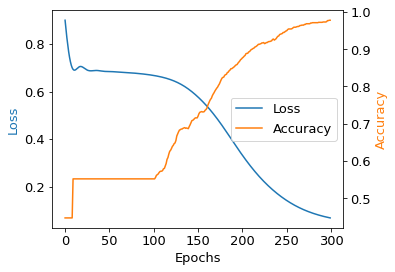

In [19]:
plot_graph(sdnn_losses,sdnn_accuracy)
test(sdnn,X_test,Y_test)

## GA-optimized BDNN (Model in this paper)

### Stage 1: GA optimises BDNN weights and biases

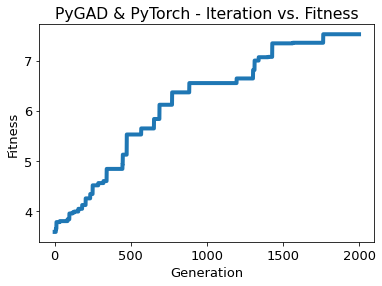

Fitness value of the best solution = 7.523859026878817
Index of the best solution : 0


<All keys matched successfully>

In [20]:
def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function1,loss_function2

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                       weights_vector=solution)

    model.load_state_dict(model_weights_dict)
    predictions = model(data_inputs)
    
    # loss BCE
    loss1=loss_function1(predictions[:,0], data_outputs[:,0]).detach().numpy()*0.1
    # loss MSE
    loss2=loss_function2(predictions[:,1], data_outputs[:,1]).detach().numpy()*0.9
    solution_fitness = 1.0 / ( loss1+loss2 + 0.00000001)

    return solution_fitness

# bdnn model initialization
model=BDNN(input_neurons, hidden_neurons, output_neurons)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=)

loss_function1 = torch.nn.BCEWithLogitsLoss()
loss_function2 = torch.nn.MSELoss()


data_inputs=X
data_outputs=Y

# Prepare the PyGAD parameters
num_generations = 200 # Number of generations.
num_parents_mating = 10 # Number of solutions to be selected as parents in the mating pool
initial_population = torch_ga.population_weights # Initial population of network weights
parent_selection_type = "sss" # Type of parent selection
crossover_type = "single_point" # Type of the crossover operator
crossover_probability=0.9 # The probability of crossover operator
mutation_type = "random" # Type of the mutation operator
mutation_percent_genes = 10# Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.
keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       crossover_probability=crossover_probability,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       keep_parents=keep_parents)

# Start the genetic algorithm evolution.
ga_instance.run()
# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_result(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)


### Stage 2: BDNN fine-tuning

In [21]:
# hyperparamters 
learning_rate = 0.02
num_epoch = 300

optimisergabdnn=torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=2e-5)
# store all losses for visualisation
ga_losses = []
ga_accuracy=[]
# train a neural network
for epoch in range(num_epoch):

    Y_pred = model(X)
    class_pre=Y_pred[:,0]
    extra_pre=Y_pred[:,1]
    
    # forward direction label Cross Entropy Loss
    loss1=loss_BCE(class_pre,Y_class)
    # perform backward pass
    loss1.backward(retain_graph=True)
    
    # forward direction extra nodes MSE
    loss2=loss_MSE(extra_pre,Y_node)
    # perform backward pass
    loss2.backward(retain_graph=True)
    
    # reverse direction input MSE
    X_pred = model.reverseforward(Y)
    lb = F.mse_loss(X_pred, X)
    # perform backward pass
    lb.backward()
    
    loss=loss1+loss2+lb
    ga_losses.append(loss)
    
    # convert output of label into probability 
    predicted=F.sigmoid(Y_pred[:,0])
    result=np.round(predicted.data.numpy())
    # calculate accuracy
    total = predicted.size(0)
    correct = result== Y_class.data.numpy()
    ga_accuracy.append(sum(correct)/total)
    
    
    if epoch % 200 == 0:
        # print accuracy
        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))
        validation(model,X_val,Y_val)
    if epoch==num_epoch-1:
        print('Confusion matrix for training:')
        print(plot_confusion(X.shape[0], output_neurons, torch.from_numpy(result).long().data, Y_class.long().data))

    # Calling the step function on an Optimiser makes an update to its parameters
    optimisergabdnn.step()
    # Clear the gradients before running the backward pass.
    model.zero_grad()

Epoch [1/300] Loss: 9.0917  Accuracy: 90.56 %
Validation Accuracy: 92.99 %
Epoch [201/300] Loss: 0.1527  Accuracy: 99.16 %
Validation Accuracy: 98.73 %
Confusion matrix for training:
tensor([[588.,   3.],
        [  0., 479.]])


## Test the GA-optimized BDNN

Pass testing data to the built neural network and get its performance

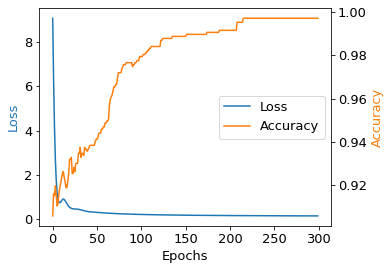

In [22]:
plot_graph(ga_losses,ga_accuracy)

In [23]:
test(model,X_test,Y_test)

Testing Accuracy: 100.00 %
Confusion matrix for testing:
tensor([[171.,   0.],
        [  0., 131.]])


## GA-optimized BDNN VS BDNN

In [11]:
# define a function to plot confusion matrix
def plot_confusion(input_sample, num_classes, des_output, actual_output):
    confusion = torch.zeros(num_classes, num_classes)
    for i in range(input_sample):
        actual_class = actual_output[i]
        predicted_class = des_output[i]
        confusion[actual_class][predicted_class] += 1
    return confusion


# plot model accuracy comparison graph
def plot_comparison_acc(accuracy1,accuracy2):
    plt.figure()
    host = host_subplot(111)  
    plt.subplots_adjust(right=0.8)

    host.set_xlabel("Epochs")
    host.set_ylabel("Accuracy")

    # plot curves
    p2, = host.plot(range(len(accuracy1)), accuracy1, label="GA-BDNN Accuracy")
    p4, = host.plot(range(len(accuracy2)), accuracy2, label="BDNN Accuracy")

    # set location of the legend
    host.legend(loc=4)

    # set label color
    host.axis["left"].label.set_color(p2.get_color())

    plt.draw()
    plt.savefig('comparison-acc.eps',dpi=300,format='eps')

    
# plot model loss comparison graph
def plot_comparison_loss(losses1,losses2):
    plt.figure()  
    host = host_subplot(111)  
    plt.subplots_adjust(right=0.8)


    host.set_xlabel("Epochs")#,fontsize=15)
    host.set_ylabel("Loss")#,fontsize=15)

    # plot curves
    p1, = host.plot(range(len(losses1)), losses1, label="GA-BDNN Loss")
    p3, = host.plot(range(len(losses2)), losses2, label="BDNN Loss")

    # set location of the legend
    host.legend(loc=5)

    # set label color
    host.axis["left"].label.set_color(p1.get_color())


    plt.draw()
    plt.savefig('comparison-loss.eps',dpi=300,format='eps')
    


    
    
# plot model accuracy vs loss graph 
def plot_graph(all_losses,all_accuracy):
    plt.figure()
    host = host_subplot(111)  
    plt.subplots_adjust(right=0.8)
    par1 = host.twinx()  

    host.set_xlabel("Epochs")
    host.set_ylabel("Loss")
    par1.set_ylabel("Accuracy")

    # plot curves
    p1, = host.plot(range(len(all_losses)), all_losses, label="Loss")
    p2, = par1.plot(range(len(all_accuracy)), all_accuracy, label="Accuracy")

    # set location of the legend
    host.legend(loc=5)

    # set label color
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())

    plt.draw()
    # plt.savefig("accuracy-vs-loss.jpg")

# validation Accuracy    
def validation(net,val_X,val_Y):
    Y_val_class=Y_val[:,0]
    Y_val_node=Y_val[:,1]
    
    outputs = net(val_X)
    predicted=outputs[:,0]
    predicted=F.sigmoid(predicted)

    total = predicted.size(0)
    result=np.round(predicted.data.numpy())

    correct = result == Y_val_class.data.numpy()

    print('Validation Accuracy: %.2f %%' % (100 * sum(correct)/total))

# testing result
def test(net,X_test,Y_test):
    outputs = net(X_test)
    predicted=F.sigmoid(outputs[:,0])
    total = predicted.size(0)
    result=np.round(predicted.data.numpy())

    correct = result == Y_test[:,0].data.numpy()
    print('Testing Accuracy: %.2f %%' % (100 * sum(correct)/total))

    # Evaluating the Results
    print('Confusion matrix for testing:')
    print(plot_confusion(X_test.shape[0], output_neurons, torch.from_numpy(result).long().data, Y_test[:,0].long().data))
    
    
def plot_test(losses1,losses2,accuracy1,accuracy2):
#     plt.figure()
#     fig, (ax1, ax2)=plt.subplot(1,2,1)
#     fig, (host, host1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)
#     host = host_subplot(121)  
#     plt.subplots_adjust(right=0.8)
    host = plt.subplot(121)
    host.set_xlabel("Epochs")#,fontsize=15)
    host.set_ylabel("Loss")#,fontsize=15)
#     host.set_ylim([0,6])
    # plot curves
    p1, = host.plot(range(len(losses1)), losses1, label="GA-BDNN Loss")
    p3, = host.plot(range(len(losses2)), losses2, label="BDNN Loss")
    # set location of the legend
    host.legend(loc=5)

    # set label color
#     host.axis["left"].label.set_color(p1.get_color())
    
    
#     plt.subplot(1,2,2)
#     host1 = host_subplot(122)  
#     plt.subplots_adjust(right=0.8)
    host1 = plt.subplot(122)
    host1.set_xlabel("Epochs")
    host1.set_ylabel("Accuracy")
#     host1.ylim(0,1)
#     host1.set_ylim([0,1])
    # plot curves
    p2, = host1.plot(range(len(accuracy1)), accuracy1, label="GA-BDNN Accuracy")
    p4, = host1.plot(range(len(accuracy2)), accuracy2, label="BDNN Accuracy")

    # set location of the legend
    host1.legend(loc=4)

    # set label color
#     host1.axis["left"].label.set_color(p2.get_color())
#     plt.subplots_adjust(bottom=0.15,wspace=1)
    plt.subplots_adjust(left=-0.5, wspace=0.25, hspace=0.25,
                    bottom=0.13, top=0.91)
    plt.savefig('comparison.eps',dpi=600,bbox_inches='tight',format='eps')
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


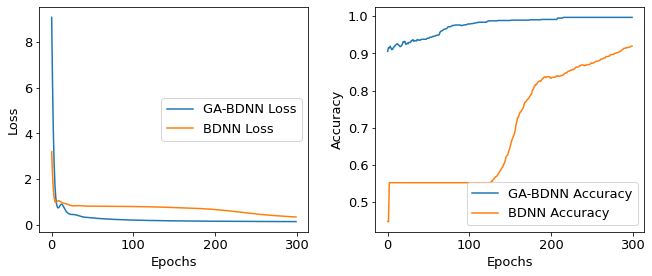

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


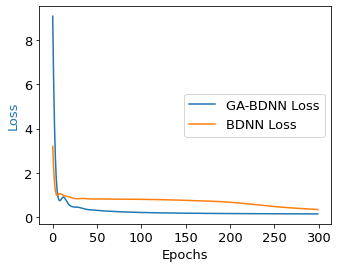

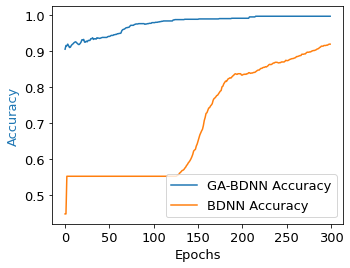

In [24]:
plot_test(ga_losses,bdnn_losses,ga_accuracy,bdnn_accuracy)
plot_comparison_loss(ga_losses,bdnn_losses)
plot_comparison_acc(ga_accuracy,bdnn_accuracy)